# pytket-dqc Example Usage

In this notebook we gather some example uses of the pytket-dqc package.

## Networks

Near term networks of quantum servers are specified by two properties. The fist is the server coupling, detailing which servers are connected to which. This is specified by a list of pairs of integers, where each pair signifies that there is a connection between those two servers. The second is the qubits each server contains. This is specified by a dictionary from the server to a list of qubits it contains. 

An example is given below, where blue lines indicate connections between servers, and red lines indicate connections between qubits within servers. The vertex labels are the indexes of the qubits.

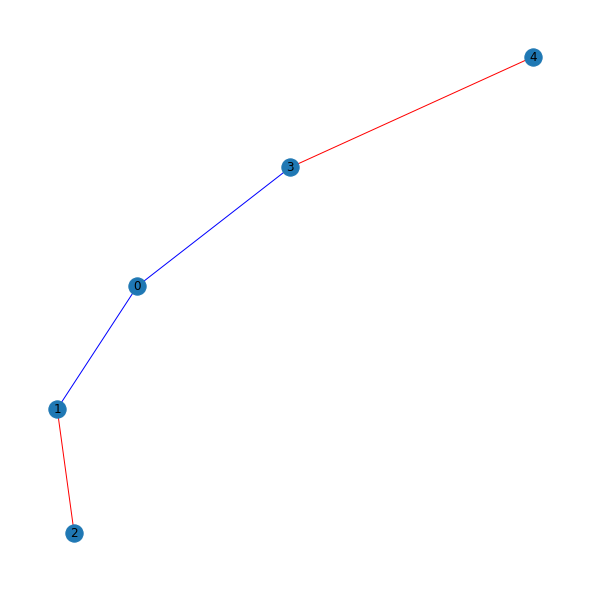

In [1]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2]], {0:[0], 1:[1,2], 2:[3,4]})
network.draw_nisq_network()

## Distributed Circuits

The DistributedCircuits class add some additional properties and methods to the standard Circuit pytket class. These predominantly relate to a hypergraph representation of the circuit. DistributedCircuits are initialised from a standard Circuit object, as seen in the following example. Additional functionality is provided to visualise the corresponding hypergraph. 

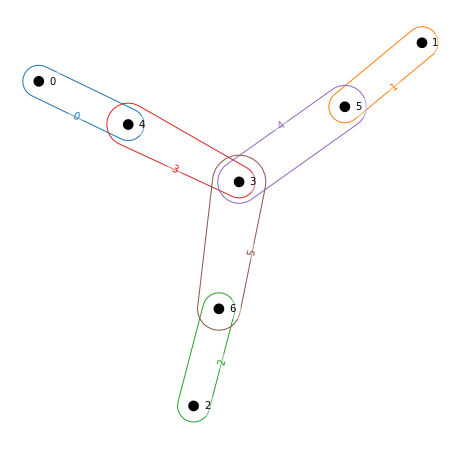

In [2]:
from pytket_dqc.circuits import DistributedCircuit
from pytket.circuit.display import render_circuit_jupyter
from pytket import Circuit

circ = Circuit(4).CZ(0,3).Rz(0.5,3).CZ(1,3).Rz(0.5,3).CZ(2,3).Rz(0.5,3)

dist_circ = DistributedCircuit(circ)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

Some classes of circuits are predefined. Cyclic circuits, where CZ gates act in a circle, are one such class of circuits. These circuits are defined by the number of qubits they act on and the number of layers of cycles.

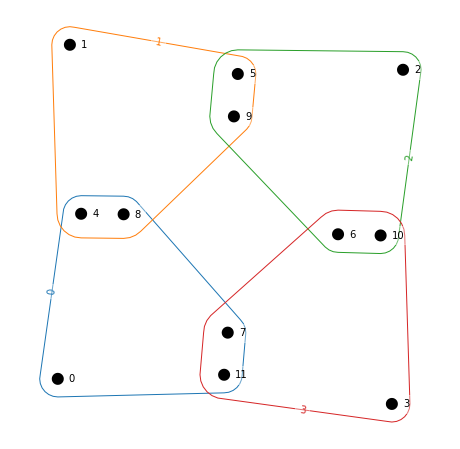

In [3]:
from pytket_dqc.circuits import CyclicDistributedCircuit

dist_circ = CyclicDistributedCircuit(4,2)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

## Distributors

pytket-dqc provides several distributors, which are themselves a selection of methods to assign qubits and gates to servers.

One such distributor is Brute, which performs a brutefoce search of all placements of qubits and gates onto servers, returning the one with the lowest cost. It is the slowest method, but returns the best result.

In [4]:
from pytket_dqc.distributors import Brute
import time

distributor = Brute()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 23.026414155960083
final placement {0: 0, 4: 0, 7: 0, 8: 0, 11: 0, 1: 1, 5: 0, 9: 0, 2: 1, 6: 0, 10: 0, 3: 2}
final placement cost 3


Annealing is another approach, which uses simulated annealing as a means to arrive at a valid placement.

In [5]:
from pytket_dqc.distributors import Annealing

distributor = Annealing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 0.7938292026519775
final placement {0: 0, 4: 1, 7: 1, 8: 1, 11: 1, 1: 2, 5: 1, 9: 1, 2: 1, 6: 1, 10: 1, 3: 1}
final placement cost 3


GraphPartitioning uses the Karlsruhe Hypergraph Partitioning Framework to derive a placement. The placements resulting from using this method may not be valid on near term networks, as it does not take into consideration limits on the numbers of qubits in each server.

In [6]:
from pytket_dqc.distributors import GraphPartitioning

distributor = GraphPartitioning()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

No filename for partition file specified 
time to distribute 0.03990507125854492
final placement {0: 1, 1: 0, 2: 0, 3: 2, 4: 1, 5: 0, 6: 2, 7: 2, 8: 1, 9: 0, 10: 2, 11: 1}


Exception: This is not a valid placement.

Routing makes use of routing and placement and routing techniques available in TKET. Here the network architecture as a whole is interpreted as a backend architecture, with noise on edges between servers set to be very high. 

In [7]:
from pytket_dqc.distributors import Routing

distributor = Routing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 0.023931026458740234
final placement {0: 0, 5: 1, 6: 0, 8: 2, 10: 0, 12: 2, 13: 0, 15: 2, 17: 0, 19: 2, 21: 1, 22: 0, 26: 1, 27: 0, 28: 1, 29: 2, 1: 1, 4: 1, 7: 1, 9: 1, 11: 1, 14: 1, 16: 1, 18: 1, 20: 1, 23: 1, 24: 1, 25: 1, 2: 1, 3: 2}
final placement cost 15
